In [2]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Run Segment Anything Model 2 on a live video stream


In [3]:
# import os
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from PIL import Image
# import cv2
# from IPython import display

In [4]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from IPython import display

In [5]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [6]:
# # use bfloat16 for the entire notebook
# torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

# if torch.cuda.get_device_properties(0).major >= 8:
#     # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
#     torch.backends.cuda.matmul.allow_tf32 = True
#     torch.backends.cudnn.allow_tf32 = True

### Loading the SAM 2 camera predictor


In [7]:
from sam2.build_sam import build_sam2_camera_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

predictor = build_sam2_camera_predictor(model_cfg, sam2_checkpoint, device=device)

In [ ]:
import cv2
import requests
import numpy as np
import torch

# SAM2 초기화 (기존과 동일)
sam2_checkpoint = "../checkpoints/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

# 디바이스 설정
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# predictor 초기화
predictor = build_sam2_camera_predictor(
    model_cfg,
    sam2_checkpoint,
    device=device
)

# WSL Stream URL 설정
url = "http://192.168.56.1:5000/video_feed"
bytes_data = b''
ann_frame_idx = 0
vis_gap = 1  # 실시간 시각화를 위해 1로 설정

# 초기 프레임 설정 변수
if_init = False
ann_obj_id = 1  # 추적할 객체의 고유 ID

# 입력 포인트와 레이블을 저장할 리스트
input_points = []
input_labels = []

# 마우스 이벤트 핸들러 함수 정의
def mouse_callback(event, x, y, flags, param):
    global input_points, input_labels
    if event == cv2.EVENT_LBUTTONDOWN:  # 왼쪽 클릭 (부정 포인트)
        input_points.append([x, y])
        input_labels.append(0)
        cv2.circle(frame, (x, y), 5, (0, 0, 255), -1)  # 빨간색 점 표시
    elif event == cv2.EVENT_RBUTTONDOWN:  # 오른쪽 클릭 (긍정 포인트)
        input_points.append([x, y])
        input_labels.append(1)
        cv2.circle(frame, (x, y), 5, (0, 255, 0), -1)  # 초록색 점 표시

try:
    cap = requests.get(url, stream=True)

    for chunk in cap.iter_content(chunk_size=1024):
        bytes_data += chunk
        a = bytes_data.find(b'\xff\xd8')  # JPEG 시작
        b = bytes_data.find(b'\xff\xd9')  # JPEG 끝

        if a != -1 and b != -1:
            jpg = bytes_data[a:b+2]
            bytes_data = bytes_data[b+2:]
            frame = cv2.imdecode(np.frombuffer(jpg, dtype=np.uint8), cv2.IMREAD_COLOR)

            ann_frame_idx += 1
            height, width = frame.shape[:2]

            # 첫 번째 프레임에서 predictor 초기화 및 마우스 클릭으로 포인트 입력
            if not if_init:
                predictor.load_first_frame(frame)
                if_init = True

                # 마우스 콜백 함수 등록
                cv2.namedWindow("First Frame - Add Points")
                cv2.setMouseCallback("First Frame - Add Points", mouse_callback)

                print("이미지에 클릭하여 포인트를 추가하세요.")
                print("왼쪽 클릭: 부정 포인트, 오른쪽 클릭: 긍정 포인트")
                print("포인트 추가 후, 'Enter' 키를 누르세요.")

                while True:
                    cv2.imshow("First Frame - Add Points", frame)
                    key = cv2.waitKey(1) & 0xFF
                    if key == 13:  # Enter 키
                        break
                    elif key == 27:  # ESC 키
                        raise Exception("사용자에 의해 종료되었습니다.")

                cv2.destroyWindow("First Frame - Add Points")

                # 입력된 포인트가 있는지 확인
                if len(input_points) > 0:
                    points = np.array(input_points, dtype=np.float32)
                    labels = np.array(input_labels, dtype=np.int32)

                    # predictor에 포인트 추가
                    _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
                        frame_idx=ann_frame_idx - 1,
                        obj_id=ann_obj_id,
                        points=points,
                        labels=labels
                    )

                    # 초기 프레임에 마스크 시각화
                    mask = (out_mask_logits[0] > 0.0).cpu().numpy()
                    mask = np.squeeze(mask)  # 불필요한 차원 제거
                    mask = (mask * 255).astype(np.uint8)
                    colored_mask = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
                    overlay = cv2.addWeighted(frame, 0.5, colored_mask, 0.5, 0)
                    cv2.imshow("Initial Mask", overlay)
                    cv2.waitKey(0)
                    cv2.destroyWindow("Initial Mask")
                else:
                    print("추가된 포인트가 없습니다.")
                    break  # 포인트가 없으면 종료

                continue  # 첫 번째 프레임에서 추적은 건너뜀

            # 이후 프레임에서 추적 실행
            out_obj_ids, out_mask_logits = predictor.track(frame)

            if ann_frame_idx % vis_gap == 0:
                print(f"Frame {ann_frame_idx}")

                if out_mask_logits is not None:
                    for obj_id, mask_logit in zip(out_obj_ids, out_mask_logits):
                        mask = (mask_logit > 0.0).cpu().numpy()
                        mask = np.squeeze(mask)  # 차원 축소
                        mask = (mask * 255).astype(np.uint8)
                        colored_mask = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
                        overlay = cv2.addWeighted(frame, 0.5, colored_mask, 0.5, 0)
                        cv2.imshow("Tracking", overlay)
                else:
                    cv2.imshow("Tracking", frame)

                if cv2.waitKey(1) & 0xFF == 27:  # ESC 키로 종료
                    break


except Exception as e:
    print(f"Error occurred: {e}")
    raise

finally:
    cv2.destroyAllWindows()


이미지에 클릭하여 포인트를 추가하세요.
왼쪽 클릭: 부정 포인트, 오른쪽 클릭: 긍정 포인트
포인트 추가 후, 'Enter' 키를 누르세요.
Frame 2
Error occurred: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/colormap.cpp:738: error: (-2:Unspecified error) in function 'void cv::colormap::ColorMap::operator()(cv::InputArray, cv::OutputArray) const'
> Not supported (expected: 'src.dims == 2'), where
>     'src.dims' is 3
> must be equal to
>     '2' is 2



/home/joongwon00/sam2/sam2/sam2_camera_predictor.py:796: UserWarning: cannot import name '_C' from 'sam2' (/home/joongwon00/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/colormap.cpp:738: error: (-2:Unspecified error) in function 'void cv::colormap::ColorMap::operator()(cv::InputArray, cv::OutputArray) const'
> Not supported (expected: 'src.dims == 2'), where
>     'src.dims' is 3
> must be equal to
>     '2' is 2


In [ ]:
# def show_mask(mask, ax, obj_id=None, random_color=False):
#     if random_color:
#         color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
#     else:
#         cmap = plt.get_cmap("tab10")
#         cmap_idx = 0 if obj_id is None else obj_id
#         color = np.array([*cmap(cmap_idx)[:3], 0.6])
#     h, w = mask.shape[-2:]
#     mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
#     ax.imshow(mask_image)


# def show_points(coords, labels, ax, marker_size=200):
#     pos_points = coords[labels == 1]
#     neg_points = coords[labels == 0]
#     ax.scatter(
#         pos_points[:, 0],
#         pos_points[:, 1],
#         color="green",
#         marker="*",
#         s=marker_size,
#         edgecolor="white",
#         linewidth=1.25,
#     )
#     ax.scatter(
#         neg_points[:, 0],
#         neg_points[:, 1],
#         color="red",
#         marker="*",
#         s=marker_size,
#         edgecolor="white",
#         linewidth=1.25,
#     )


# def show_bbox(bbox, ax, marker_size=200):
#     tl, br = bbox[0], bbox[1]
#     w, h = (br - tl)[0], (br - tl)[1]
#     x, y = tl[0], tl[1]
#     print(x, y, w, h)
#     ax.add_patch(plt.Rectangle((x, y), w, h, fill=None, edgecolor="blue", linewidth=2))

#### Select an video stream (video or camera)


In [ ]:
# cap = cv2.VideoCapture("videos/bedroom.mp4")
# ret, frame = cap.read()
# width, height = frame.shape[:2][::-1]

#### Step 1: Add a first click on the first frame


/home/joongwon00/sam2/sam2/sam2_camera_predictor.py:1076: UserWarning: cannot import name '_C' from 'sam2' (/home/joongwon00/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


600.0 214.0 165.0 72.0


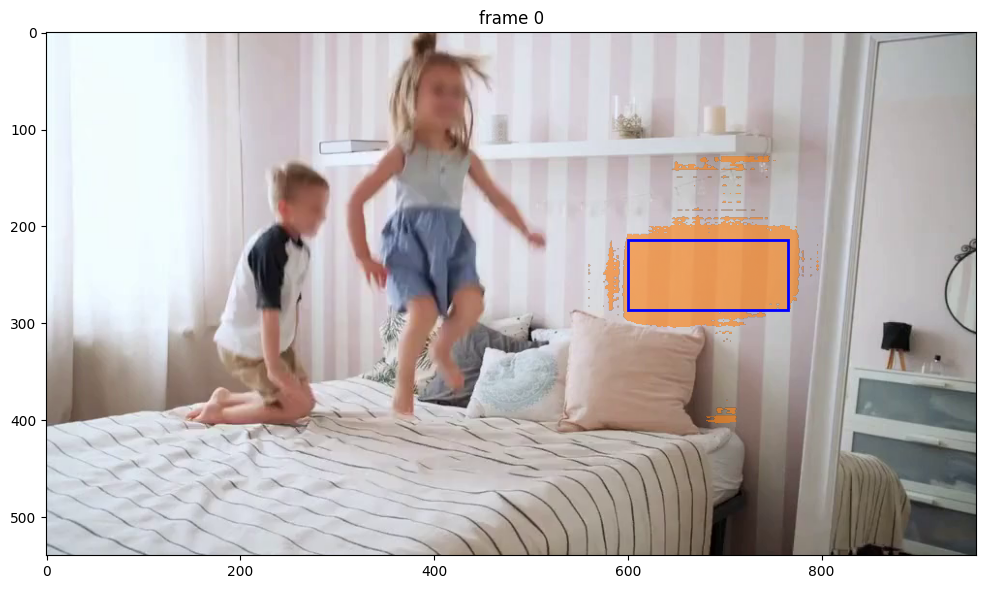

In [ ]:
# predictor.load_first_frame(frame)
# if_init = True

# using_point = False # if True, we use point prompt
# using_box = True # if True, we use point prompt
# using_mask= False  # if True, we use mask prompt

# ann_frame_idx = 0  # the frame index we interact with
# ann_obj_id = (
#     1  # give a unique id to each object we interact with (it can be any integers)
# )
# # Let's add a positive click at (x, y) = (210, 350) to get started

# # using point prompt
# points = np.array([[670, 247]], dtype=np.float32)
# # for labels, `1` means positive click and `0` means negative click
# labels = np.array([1], dtype=np.int32)
# bbox = np.array([[600, 214], [765, 286]], dtype=np.float32)

# frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
# plt.figure(figsize=(12, 8))
# plt.title(f"frame {ann_frame_idx}")
# plt.imshow(frame)


# if using_point:
#     _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
#         frame_idx=ann_frame_idx,
#         obj_id=ann_obj_id,
#         points=points,
#         labels=labels,
#     )
#     show_points(points, labels, plt.gca())

# elif using_box:
#     _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
#         frame_idx=ann_frame_idx, obj_id=ann_obj_id, bbox=bbox
#     )
#     show_bbox(bbox, plt.gca())

# elif using_mask:
#     mask_img_path="masks/aquarium/aquarium_mask.png"
#     mask = cv2.imread(mask_img_path, cv2.IMREAD_GRAYSCALE)
#     mask = mask / 255

#     _, out_obj_ids, out_mask_logits = predictor.add_new_mask(
#         frame_idx=ann_frame_idx, obj_id=ann_obj_id, mask=mask
#     )
    


# show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

#### Step 2: track


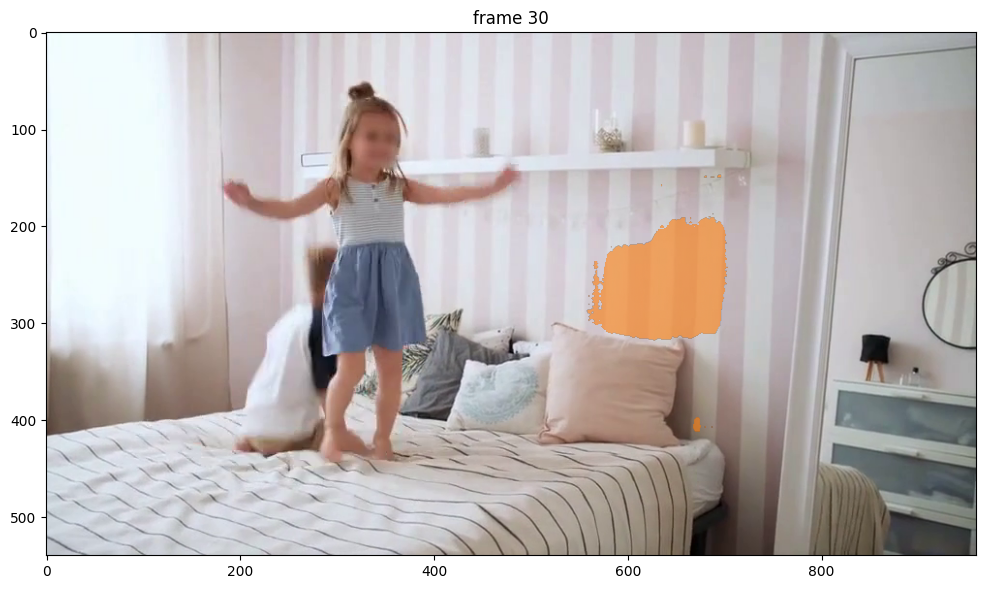

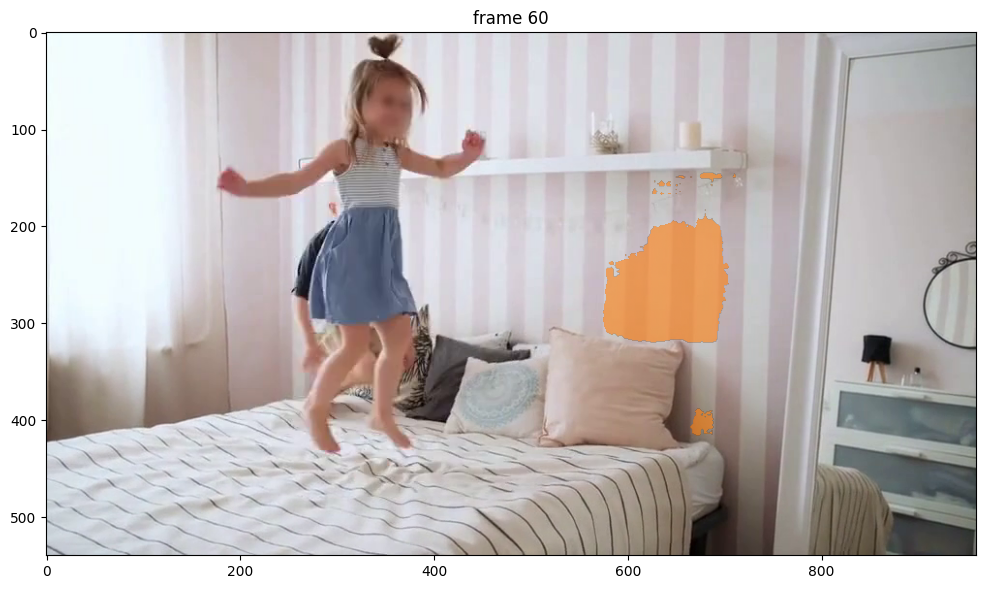

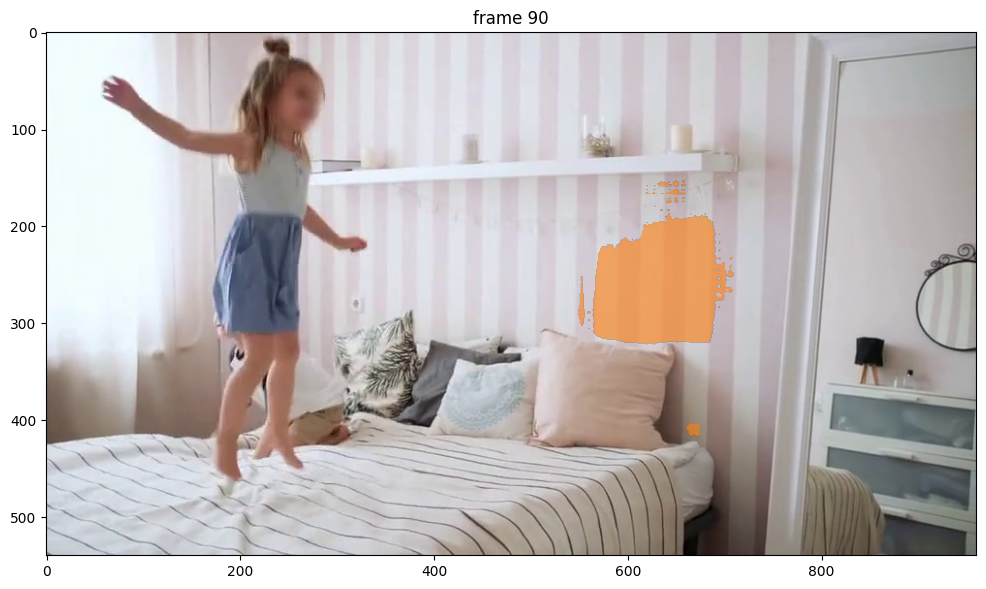

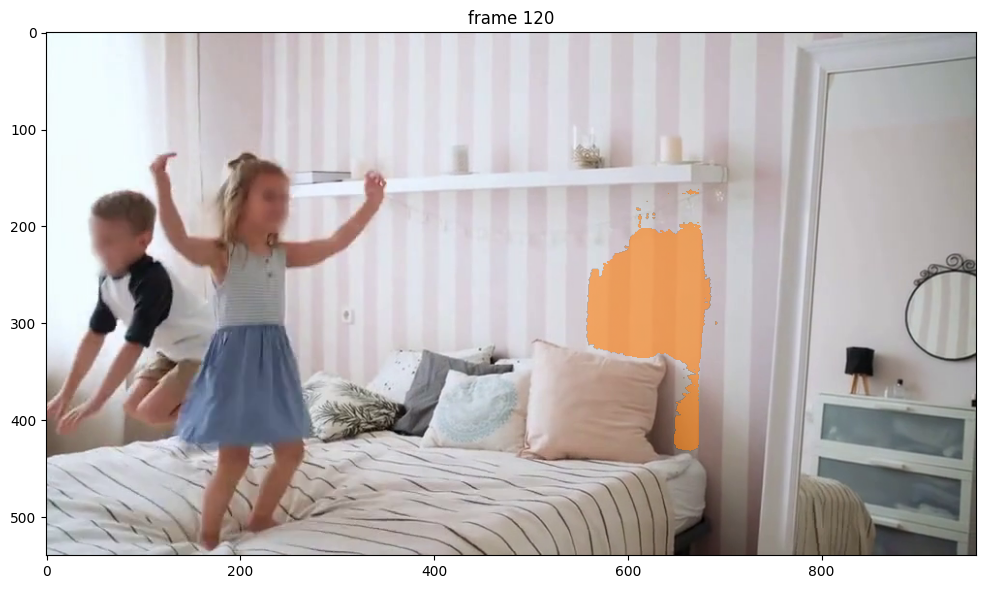

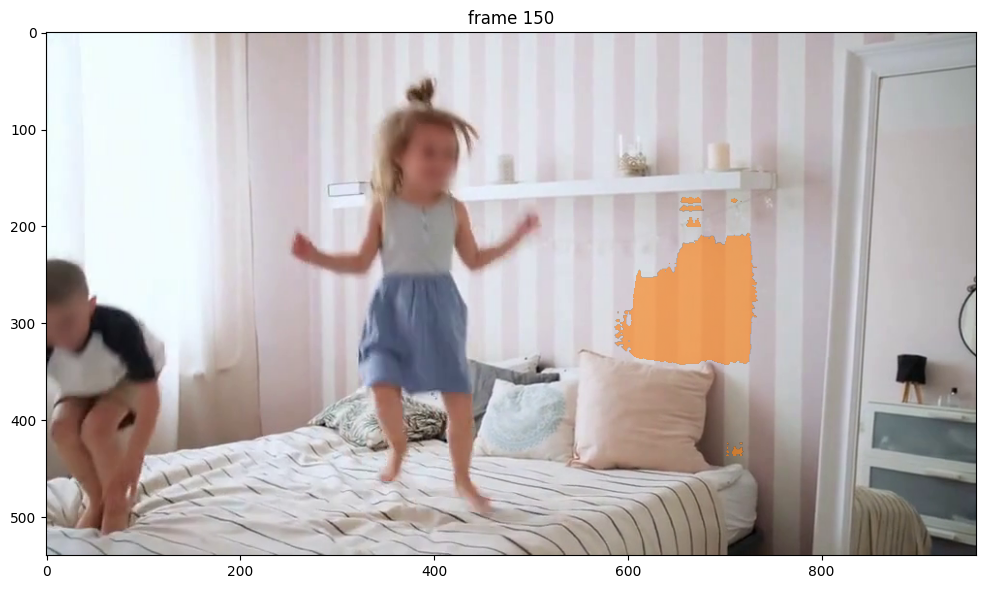

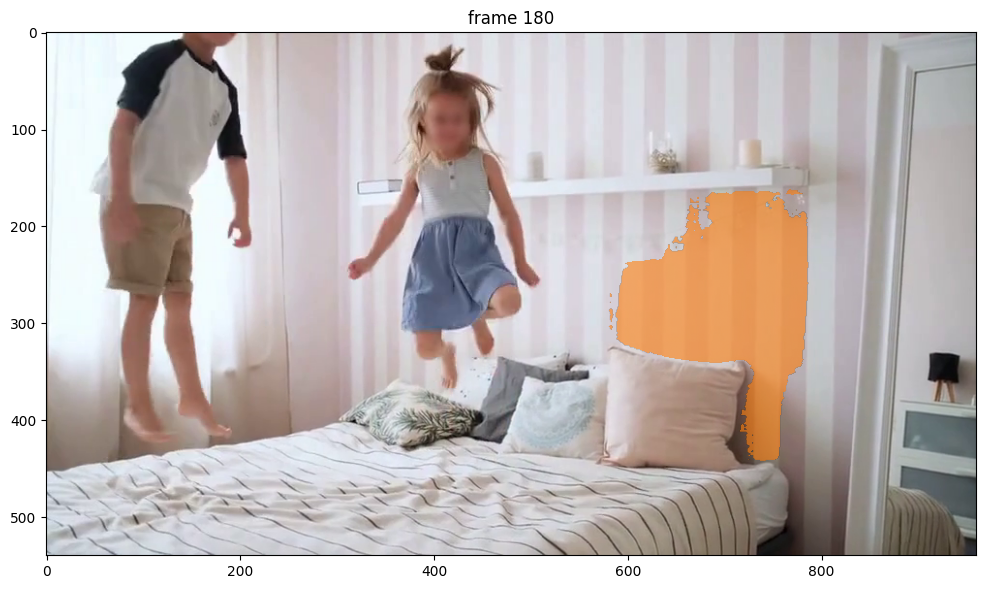

In [ ]:
# vis_gap = 30

# while True:

#     ret, frame = cap.read()
#     ann_frame_idx += 1
#     if not ret:
#         break
#     width, height = frame.shape[:2][::-1]

#     out_obj_ids, out_mask_logits = predictor.track(frame)

#     if ann_frame_idx % vis_gap == 0:
#         print(f"frame {ann_frame_idx}")
#         frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         display.clear_output(wait=True)
#         plt.figure(figsize=(12, 8))
#         plt.title(f"frame {ann_frame_idx}")
#         plt.imshow(frame)
#         show_mask(
#             (out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0]
#         )

# cap.release()